In [12]:
import collections
import warnings

import numpy as np 
import pandas as pd 
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt 

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.util import nest
from tensorflow.python.keras import backend
from tensorflow.python.framework import tensor_shape
from tensorflow.python.keras.utils import generic_utils

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from matplotlib import style

In [13]:
# Allowing GPU compatibility of tensorflow graph data structures 

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\marco\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### Custom NNN Classes

In [14]:
# Implementing the neuron as an MLP Custom Layer in order for it 
# to be treated as a single neuron by TF

class NetNetCell(keras.layers.Layer):
    def __init__(self, shape, num_axons, ax_activation='relu', d_activation='relu', **kwargs):
        super(NetNetCell, self).__init__(**kwargs)

        self.shape = shape                                          # shape of neuron
        self.num_axons = num_axons                                  # output dimension of neuron
        self.ax_activation = keras.activations.get(ax_activation)
        self.d_activation = keras.activations.get(d_activation)

        self.num_layers = len(self.shape)
        # internal hidden Dense layers generated by the shape list 
        self.layers = [keras.layers.Dense(self.shape[i], activation=self.d_activation, trainable=True)
                        for i in range(self.num_layers)]
        self.axon = keras.layers.Dense(self.num_axons, activation=self.ax_activation, trainable=True)

        # builds the custom layer
        def build(self, input_shape):
            # keras has problems building elements inside lists as instantiated in self.layers 
            # this code makes sure layers get built
            if isinstance(input_shape, list):
                input_shape = input_shape[0]
            for lay in range(num_layers):
                if isinstance(lay, keras.layers.Layer) and not lay.built:
                    with backend.name_scope(lay.name):
                        lay.build(input_shape)
                        lay.built = True
                if getattr(lay, 'output_size', None) is not None:
                    output_dim = lay.output_size
                elif _is_multiple_state(lay.state_size):
                    output_dim = lay.state_size[0]
                else:
                    output_dim = lay.state_size
                input_shape = tuple([input_shape[0]] + tensor_shape.TensorShape(output_dim).as_list())
            self.built = True

    
    @property
    def output_size(self):      # keras needs it for connection to next layer
        return self.num_axons
        
    @tf.function
    # computes custom layer output from inputs (x = inputs)
    def call(self, x):          # straightforward functional implementation of an MLP
        for lay in self.layers:
            x = lay(x)
        x = self.axon(x)
        return x

In [15]:
# NNN Layer implementation as parallelization of NNN Cells

class NetNetLayer(keras.layers.Layer):
    def __init__(self, cells, **kwargs):
        super(NetNetLayer, self).__init__(**kwargs)
        self.cells = cells      # In order to build a NetNetLayer one has to feed as an argument a list of cells
                                # these cells can actually be whatever but in our case we'll be using NetNetCells

    def build(self, input_shape):
        # keras has problems building elements inside lists as instantiated in self.cells (which are lists) 
        # this code makes sure layers get built
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        for cell in self.cells:
            if isinstance(cell, keras.layers.Layer) and not cell.built:
                with backend.name_scope(cell.name):
                    cell.build(input_shape)
                    cell.built = True
            if getattr(cell, 'output_size', None) is not None:
                output_dim = cell.output_size
            elif _is_multiple_state(cell.state_size):
                output_dim = cell.state_size[0]
            else:
                output_dim = cell.state_size
            input_shape = tuple([input_shape[0]] + tensor_shape.TensorShape(output_dim).as_list())
        self.built = True

    
    @property
    def output_size(self):      # keras needs it for connection to next layer
        return (self.cells[0].output_size * len(self.cells))

    # computes custom layer output from inputs (x = inputs)
    @tf.function
    def call(self, inputs):     # Serialized calculation of each neuron's output
        nested_outputs = []
        for cell in self.cells:
            x = cell(inputs)
            nested_outputs.append(x)
        return nest.pack_sequence_as(self.output_size, nest.flatten(tf.concat(nested_outputs, axis=1)))
        # then the outputs list gets concatted, flattened and reshaped 
        # in order for it to be seen from the next layer as a single tensor

### Database Reading

In [16]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [17]:
val_size = .1 

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=val_size, stratify=y_train_full)

In [18]:
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

In [19]:
n_classes=10

y_train_cat = keras.utils.to_categorical(y_train, n_classes)
y_valid_cat = keras.utils.to_categorical(y_valid, n_classes)
y_test_cat = keras.utils.to_categorical(y_test, n_classes)

### Reference Fully Connected MLP

In [10]:
keras.backend.clear_session()

inputs = keras.layers.Input(shape=(28,28))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(20, activation='relu')(x)
x = keras.layers.Dense(20, activation='relu')(x)
out = keras.layers.Dense(10, activation='softmax')(x)

fc_1 = keras.Model(inputs=inputs, outputs=out)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                15700     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
_________________________________________________________________


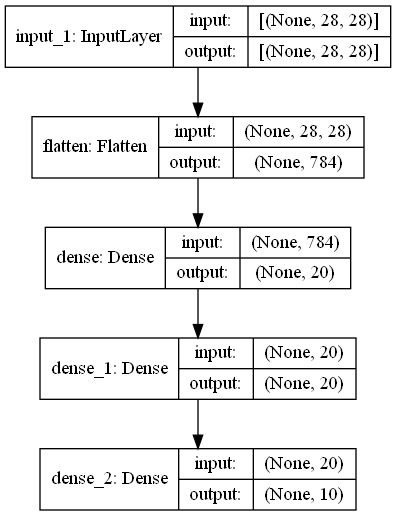

In [11]:
fc_1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
fc_1.summary()
keras.utils.plot_model(fc_1, show_shapes=True)

In [12]:
history = fc_1.fit(X_train, y_train_cat, epochs=30, validation_data=(X_valid, y_valid_cat))

# sorry but I lost the output of this cell 

Epoch 1/30
 774/1688 [============>.................] - ETA: 3s - loss: 0.6998 - accuracy: 0.7580

KeyboardInterrupt: 

<function matplotlib.pyplot.show(close=None, block=None)>

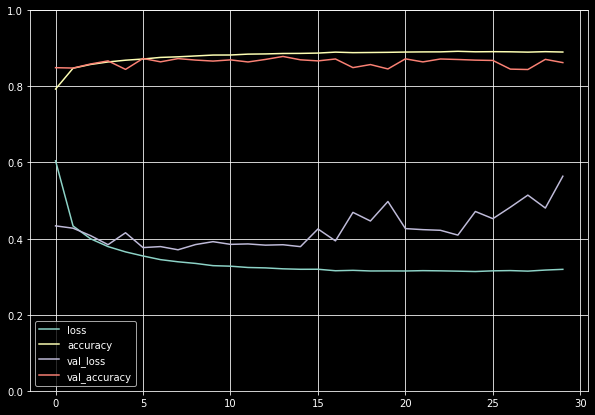

In [42]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show

In [47]:
#evaluate model on the test set
test_loss, test_acc = fc_1.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.4777 - accuracy: 0.8596

Test Loss:	 0.4776720702648163
Test Accuracy:	 0.8596000075340271


In [48]:
y_test_cat.shape
y_pred.shape

(10000, 10)

In [49]:
y_pred_seq = np.argmax(y_pred,axis=1)

In [29]:
cm = confusion_matrix(y_test, y_pred_seq)

In [61]:
style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

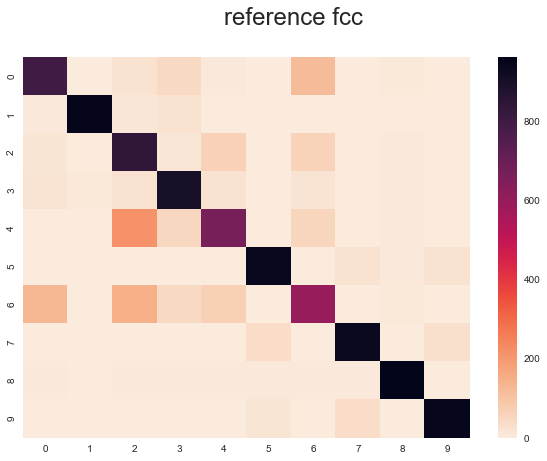

In [61]:
style.use('seaborn')
fig = plt.figure(figsize=[10,7])
fig.suptitle('reference fcc', fontsize=24)
sb.heatmap(cm, cmap='rocket_r')

### First NNN Model: Simple

In [20]:
keras.backend.clear_session()

#create neurons
neurons_1 = [NetNetCell(shape=[2,2,2], num_axons=1) for _ in range(20)]
neurons_2 = [NetNetCell(shape=[2,2,2], num_axons=1) for _ in range(20)]

inputs = keras.layers.Input(shape=(28,28))
x = keras.layers.Flatten()(inputs) 

# insert neurons in layers 
x = NetNetLayer(neurons_1)(x)
x = NetNetLayer(neurons_2)(x)
out = keras.layers.Dense(10, activation='softmax')(x)

nnn_1 = keras.Model(inputs=inputs, outputs=out)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
net_net_layer (NetNetLayer)  (None, 20)                31700     
_________________________________________________________________
net_net_layer_1 (NetNetLayer (None, 20)                1140      
_________________________________________________________________
dense_160 (Dense)            (None, 10)                210       
Total params: 33,050
Trainable params: 33,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1688/1688 [==============================] - 251s 140ms/step - loss: 0.7877 - accuracy: 0.7204 - val_loss: 0.531

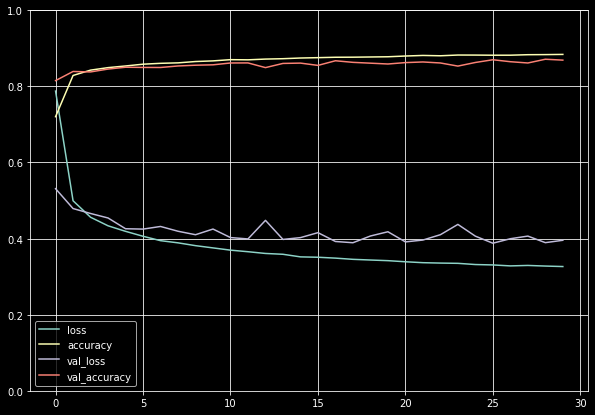

In [21]:
nnn_1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
nnn_1.summary()

keras.utils.plot_model(nnn_1, show_shapes=True)

history = nnn_1.fit(X_train, y_train_cat, epochs=30, validation_data=(X_valid, y_valid_cat))

pd.DataFrame(history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show

test_loss, test_acc = nnn_1.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

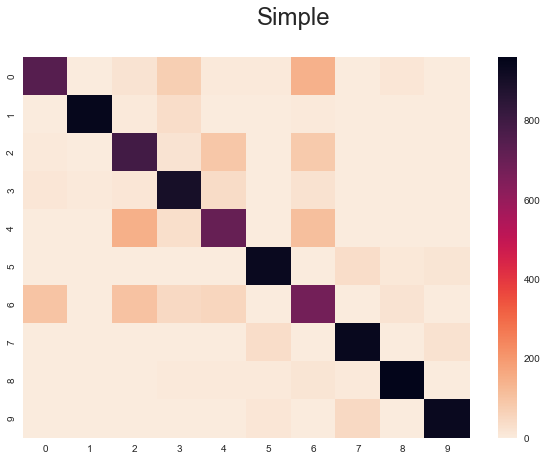

In [22]:
y_pred = nnn_1.predict(X_test)
y_pred_seq = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_test, y_pred_seq)

style.use('seaborn')
fig = plt.figure(figsize=[10,7])
fig.suptitle('Simple', fontsize=24)
sb.heatmap(cm, cmap='rocket_r')
mpl.rcParams['text.color'] = 'blue'

### NNN Model: Big Neurons

In [65]:
keras.backend.clear_session()

#create neurons
neurons_1 = [NetNetCell(shape=[200,100,100], num_axons=10) for _ in range(20)]
neurons_2 = [NetNetCell(shape=[200,100,100], num_axons=10) for _ in range(20)]

inputs = keras.layers.Input(shape=(28,28))
x = keras.layers.Flatten()(inputs)
x = NetNetLayer(neurons_1)(x)
x = NetNetLayer(neurons_2)(x)
out = keras.layers.Dense(10, activation='softmax')(x)

big = keras.Model(inputs=inputs, outputs=out)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
net_net_layer (NetNetLayer)  (None, 200)               3764200   
_________________________________________________________________
net_net_layer_1 (NetNetLayer (None, 200)               1428200   
_________________________________________________________________
dense_160 (Dense)            (None, 10)                2010      
Total params: 5,194,410
Trainable params: 5,194,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1688/1688 [==============================] - 247s 139ms/step - loss: 0.5989 - accuracy: 0.7858 - val_loss:

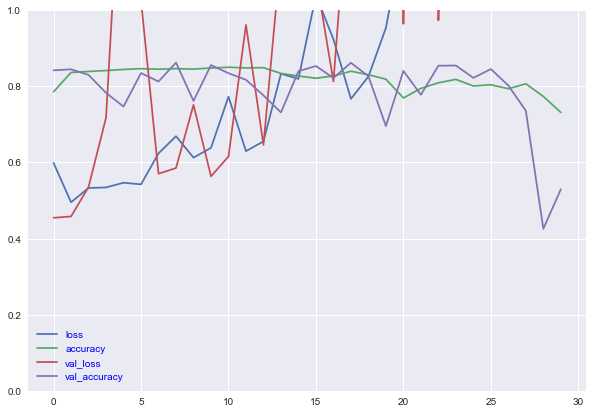

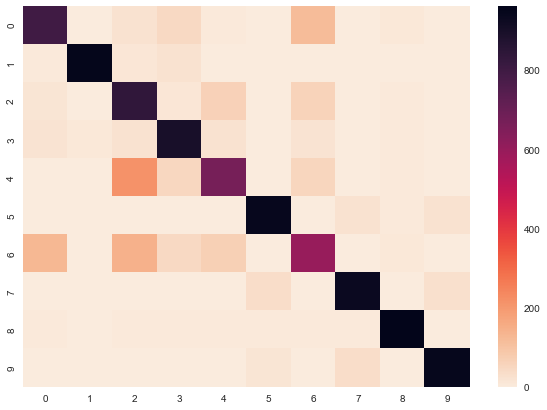

In [66]:
big.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
big.summary()

keras.utils.plot_model(big, show_shapes=True)

history = big.fit(X_train, y_train_cat, epochs=30, validation_data=(X_valid, y_valid_cat))

pd.DataFrame(history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show

#evaluate model on the test set
test_loss, test_acc = big.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)



313/313 [==============================] - 7s 22ms/step - loss: 2.8870 - accuracy: 0.5271

Test Loss:	 2.8869690895080566
Test Accuracy:	 0.5271000266075134


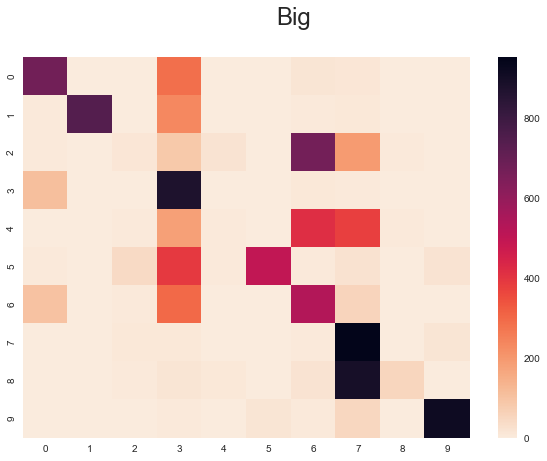

In [80]:
test_loss, test_acc = big.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

y_pred = big.predict(X_test)
y_pred_seq = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_test, y_pred_seq)

style.use('seaborn')
fig = plt.figure(figsize=[10,7])
fig.suptitle('Big', fontsize=24)
sb.heatmap(cm, cmap='rocket_r')
mpl.rcParams['text.color'] = 'blue'

### NNN Model: Pyramidal

In [72]:
keras.backend.clear_session()

#create neurons
neurons_1 = [NetNetCell(shape=[7,7,5], num_axons=1) for _ in range(112)]
neurons_2 = [NetNetCell(shape=[4,4,3], num_axons=1) for _ in range(28)]

inputs = keras.layers.Input(shape=(28,28))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(748, activation='relu')(x)
x = NetNetLayer(neurons_1)(x)
x = NetNetLayer(neurons_2)(x)
out = keras.layers.Dense(10, activation='softmax')(x)

Aureal = keras.Model(inputs=inputs, outputs=out)

In [73]:
Aureal.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
Aureal.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_560 (Dense)            (None, 748)               587180    
_________________________________________________________________
net_net_layer (NetNetLayer)  (None, 112)               598640    
_________________________________________________________________
net_net_layer_1 (NetNetLayer (None, 28)                13748     
_________________________________________________________________
dense_561 (Dense)            (None, 10)                290       
Total params: 1,199,858
Trainable params: 1,199,858
Non-trainable params: 0
___________________________________________________

In [74]:
Aureal.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
Aureal.summary()

keras.utils.plot_model(Aureal, show_shapes=True)

Aureal_history = Aureal.fit(X_train, y_train_cat, epochs=30, validation_data=(X_valid, y_valid_cat))



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_560 (Dense)            (None, 748)               587180    
_________________________________________________________________
net_net_layer (NetNetLayer)  (None, 112)               598640    
_________________________________________________________________
net_net_layer_1 (NetNetLayer (None, 28)                13748     
_________________________________________________________________
dense_561 (Dense)            (None, 10)                290       
Total params: 1,199,858
Trainable params: 1,199,858
Non-trainable params: 0
___________________________________________________

<function matplotlib.pyplot.show(close=None, block=None)>

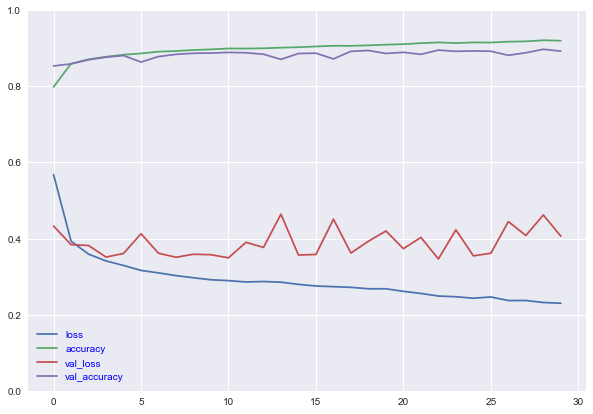

In [75]:
pd.DataFrame(Aureal_history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show


In [76]:
test_loss, test_acc = Aureal.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

313/313 [==============================] - 23s 72ms/step - loss: 0.4578 - accuracy: 0.8779

Test Loss:	 0.4577847123146057
Test Accuracy:	 0.8779000043869019


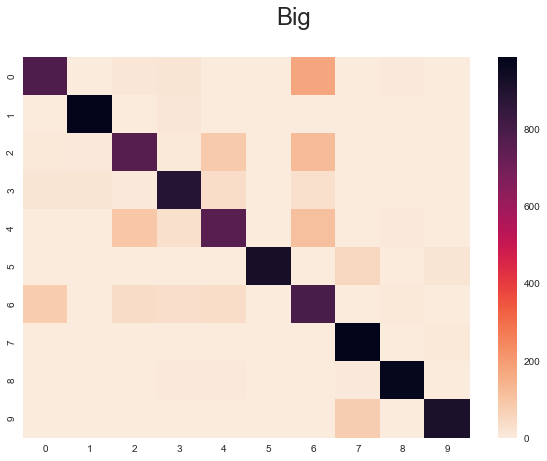

In [77]:
y_pred = Aureal.predict(X_test)
y_pred_seq = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_test, y_pred_seq)



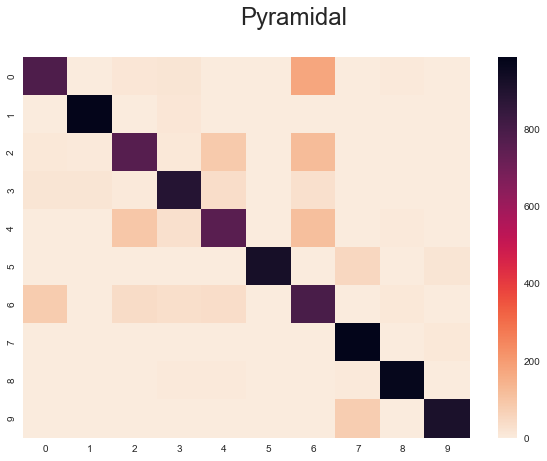

In [79]:
style.use('seaborn')
fig = plt.figure(figsize=[10,7])
fig.suptitle('Pyramidal', fontsize=24)
sb.heatmap(cm, cmap='rocket_r')
mpl.rcParams['text.color'] = 'blue'

### Pyramidal MLP Comparation 

In [94]:
keras.backend.clear_session()

inputs = keras.layers.Input(shape=(28,28))
x = keras.layers.Flatten()(inputs)
y = keras.layers.Dense(748, activation='relu')(x)
z = keras.layers.Dense(112, activation='relu')(y)
k = keras.layers.Dense(28, activation='relu')(z)
out = keras.layers.Dense(10, activation='softmax')(k)

aur_comp = keras.Model(inputs=inputs, outputs=out)

In [85]:
aur_comp.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
aur_comp.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
aur_comp.summary()

keras.utils.plot_model(aur_comp, show_shapes=True)

aur_comp_history = aur_comp.fit(X_train, y_train_cat, epochs=30, validation_data=(X_valid, y_valid_cat))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 748)               587180    
_________________________________________________________________
dense_1 (Dense)              (None, 112)               83888     
_________________________________________________________________
dense_2 (Dense)              (None, 28)                3164      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                290       
Total params: 674,522
Trainable params: 674,522
Non-trainable params: 0
_______________________________________________________

<function matplotlib.pyplot.show(close=None, block=None)>

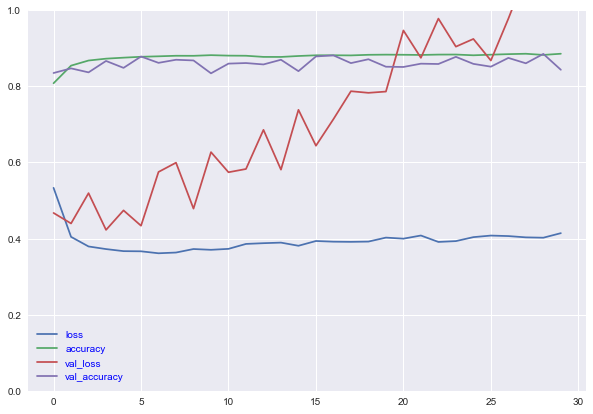

In [87]:
pd.DataFrame(aur_comp_history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show


In [88]:
#evaluate model on the test set
test_loss, test_acc = aur_comp.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 1.1568 - accuracy: 0.8378

Test Loss:	 1.15675950050354
Test Accuracy:	 0.8378000259399414


In [89]:
y_pred = aur_comp.predict(X_test)
y_pred_seq = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_test, y_pred_seq)



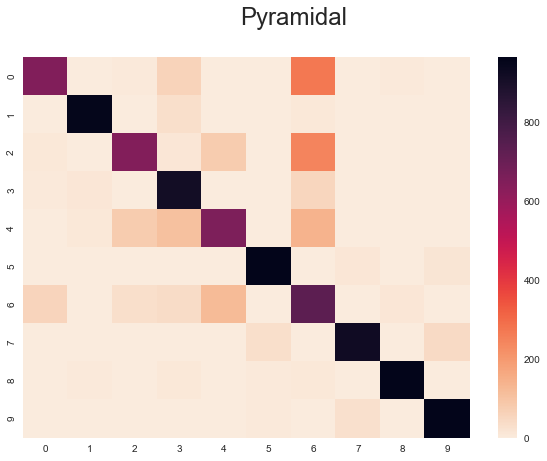

In [90]:
style.use('seaborn')
fig = plt.figure(figsize=[10,7])
fig.suptitle('Pyramidal', fontsize=24)
sb.heatmap(cm, cmap='rocket_r')
mpl.rcParams['text.color'] = 'blue'

### NNN Model: Deep

In [97]:
keras.backend.clear_session()

#create neurons (beware you cannot use the same neuron list for all layers)
neurons_1 = [NetNetCell(shape=[5,5,5], num_axons=1) for _ in range(50)]
neurons_2 = [NetNetCell(shape=[5,5,5], num_axons=1) for _ in range(50)]
neurons_3 = [NetNetCell(shape=[5,5,5], num_axons=1) for _ in range(50)]
neurons_4 = [NetNetCell(shape=[5,5,5], num_axons=1) for _ in range(50)]

inputs = keras.layers.Input(shape=(28,28))
x = keras.layers.Flatten()(inputs)
x = NetNetLayer(neurons_1)(x)
x = NetNetLayer(neurons_2)(x)
x = NetNetLayer(neurons_3)(x)
x = NetNetLayer(neurons_4)(x)
out = keras.layers.Dense(10, activation='softmax')(x)

Deep = keras.Model(inputs=inputs, outputs=out)

In [98]:
Deep.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
Deep.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
net_net_layer (NetNetLayer)  (None, 50)                199550    
_________________________________________________________________
net_net_layer_1 (NetNetLayer (None, 50)                16050     
_________________________________________________________________
net_net_layer_2 (NetNetLayer (None, 50)                16050     
_________________________________________________________________
net_net_layer_3 (NetNetLayer (None, 50)                16050     
_________________________________________________________________
dense_1000 (Dense)           (None, 10)                510   

In [111]:
Deep_history = Deep.fit(X_train, y_train_cat, epochs=30, validation_data=(X_valid, y_valid_cat))

Epoch 1/30
1688/1688 [==============================] - 1165s 690ms/step - loss: 0.6558 - accuracy: 0.7652 - val_loss: 0.5247 - val_accuracy: 0.8168
Epoch 2/30
1688/1688 [==============================] - 1161s 688ms/step - loss: 0.4374 - accuracy: 0.8434 - val_loss: 0.4172 - val_accuracy: 0.8547
Epoch 3/30
1688/1688 [==============================] - 1160s 687ms/step - loss: 0.3978 - accuracy: 0.8585 - val_loss: 0.4006 - val_accuracy: 0.8637
Epoch 4/30
1688/1688 [==============================] - 1175s 696ms/step - loss: 0.3767 - accuracy: 0.8639 - val_loss: 0.4036 - val_accuracy: 0.8543
Epoch 5/30
1688/1688 [==============================] - 1165s 690ms/step - loss: 0.3619 - accuracy: 0.8712 - val_loss: 0.3965 - val_accuracy: 0.8662
Epoch 6/30
1688/1688 [==============================] - 1157s 686ms/step - loss: 0.3509 - accuracy: 0.8772 - val_loss: 0.3801 - val_accuracy: 0.8690
Epoch 7/30
1688/1688 [==============================] - 1092s 647ms/step - loss: 0.3475 - accuracy: 0.8776

<function matplotlib.pyplot.show(close=None, block=None)>

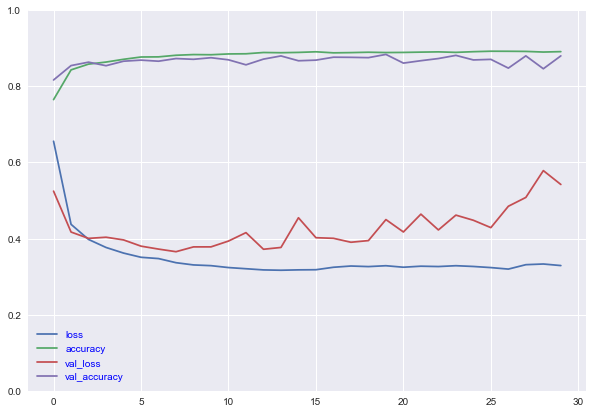

In [112]:
pd.DataFrame(Deep_history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show

In [113]:
#evaluate model on the test set
test_loss, test_acc = Deep.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

313/313 [==============================] - 32s 101ms/step - loss: 0.5961 - accuracy: 0.8694

Test Loss:	 0.5960775017738342
Test Accuracy:	 0.8694000244140625


In [114]:
y_pred = Deep.predict(X_test)
y_pred_seq = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_test, y_pred_seq)

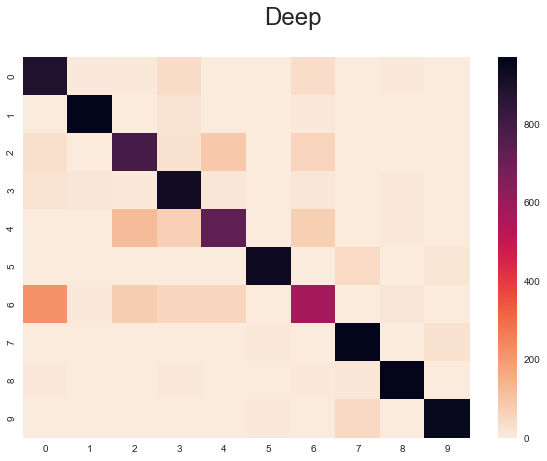

In [116]:
style.use('seaborn')
fig = plt.figure(figsize=[10,7])
fig.suptitle('Deep', fontsize=24)
sb.heatmap(cm, cmap='rocket_r')
mpl.rcParams['text.color'] = 'blue'

### Deep MLP Comparation

In [118]:
keras.backend.clear_session()

#create neurons (beware you cannot use the same neuron list for all layers)
inputs = keras.layers.Input(shape=(28,28))
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dense(50, activation='relu')(x)
x = keras.layers.Dense(50, activation='relu')(x)
out = keras.layers.Dense(10, activation='softmax')(x)

Deep_compa = keras.Model(inputs=inputs, outputs=out)

In [119]:
Deep_compa.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
Deep_compa.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                39250     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510   

In [120]:
Deep_compa_history = Deep_compa.fit(X_train, y_train_cat, epochs=30, validation_data=(X_valid, y_valid_cat))

Epoch 1/30
1688/1688 [==============================] - 11s 6ms/step - loss: 0.5560 - accuracy: 0.7997 - val_loss: 0.4062 - val_accuracy: 0.8537
Epoch 2/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.4076 - accuracy: 0.8522 - val_loss: 0.5135 - val_accuracy: 0.8178
Epoch 3/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.3740 - accuracy: 0.8637 - val_loss: 0.3706 - val_accuracy: 0.8680
Epoch 4/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.3559 - accuracy: 0.8707 - val_loss: 0.4063 - val_accuracy: 0.8590
Epoch 5/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.3450 - accuracy: 0.8767 - val_loss: 0.3921 - val_accuracy: 0.8607
Epoch 6/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.3436 - accuracy: 0.8783 - val_loss: 0.3780 - val_accuracy: 0.8758
Epoch 7/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.3404 - accuracy: 0.8794 - val_loss: 0.3710 - val_ac

<function matplotlib.pyplot.show(close=None, block=None)>

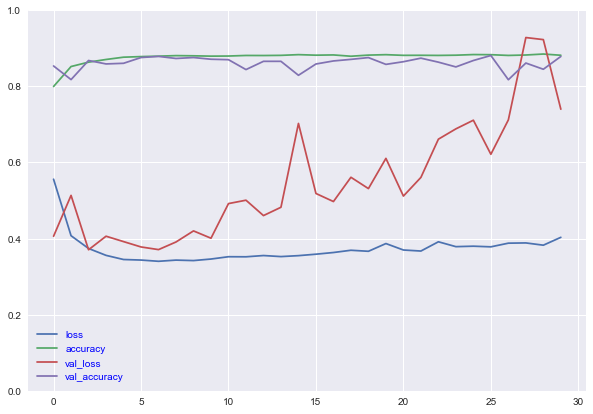

In [121]:
pd.DataFrame(Deep_compa_history.history).plot(figsize=(10,7))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show

In [122]:
#evaluate model on the test set
test_loss, test_acc = Deep_compa.evaluate(X_test, y_test_cat)

print()
print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.8212 - accuracy: 0.8704

Test Loss:	 0.8211576342582703
Test Accuracy:	 0.8704000115394592


In [123]:
y_pred = Deep_compa.predict(X_test)
y_pred_seq = np.argmax(y_pred,axis=1)
cm = confusion_matrix(y_test, y_pred_seq)

<AxesSubplot:>

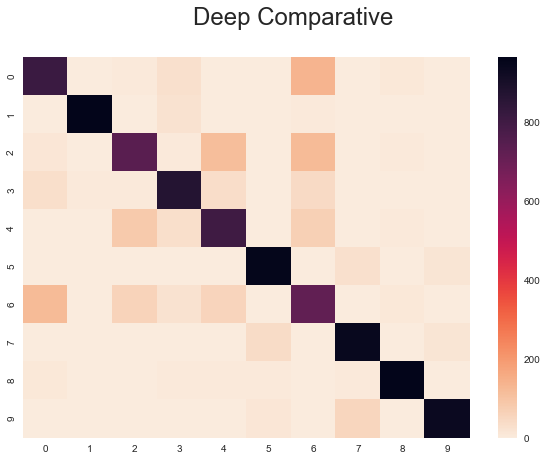

In [126]:
style.use('seaborn')
fig = plt.figure(figsize=[10,7])
fig.suptitle('Deep Comparative', fontsize=24)
sb.heatmap(cm, cmap='rocket_r')